# Load Amazon_fashion_5core dataset in PyG

In [2]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric pyglib -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install ogb  # for datasets
!pip install torchtext

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.3/497.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.7/745.7 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyglib: filename=pyglib-0.1-py2.py3-none-any.whl size=4529 sha256=414e56860d09b690d5cbe175ddee225a271d3adabbab405e485d65398d0707cb
  Stored in directory: /root/.cache/pip/wheels/3d/40/74/f2d023081eff881e653d4fe966b0f8603ae85e189062317f8f
  Created wheel for python-gflags: filename=python_gflags-3.1.2-py3-none-any.whl size=57370 sha256=38ffe116db42

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


In [31]:
import os.path as osp
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
from torch_geometric.loader import LinkLoader, DataLoader,NeighborLoader, LinkNeighborLoader
from torch_geometric.explain import CaptumExplainer, Explainer
import matplotlib.pyplot as plt

In [4]:
df = pd.read_json('/content/drive/MyDrive/data/AMAZON_FASHION_5.json', lines=True)
df.head()


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Orange'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
1,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Black (3746...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
2,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Gray L...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
3,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue (37867...",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN
4,5,True,"09 4, 2015",ALJ66O1Y6SLHA,B000K2PJ4K,"{'Size:': ' Big Boys', 'Color:': ' Blue/Pink'}",Tonya B.,Great product and price!,Five Stars,1441324800,NaN,NaN


In [ ]:
df.drop(['style', 'image', 'verified', 'summary', 'reviewTime', 'unixReviewTime', 'vote'], axis=1, inplace=True)
df.head()

,overall,reviewerID,asin,reviewerName,reviewText
0,5,ALJ66O1Y6SLHA,B000K2PJ4K,Tonya B.,Great product and price!
1,5,ALJ66O1Y6SLHA,B000K2PJ4K,Tonya B.,Great product and price!
2,5,ALJ66O1Y6SLHA,B000K2PJ4K,Tonya B.,Great product and price!
3,5,ALJ66O1Y6SLHA,B000K2PJ4K,Tonya B.,Great product and price!
4,5,ALJ66O1Y6SLHA,B000K2PJ4K,Tonya B.,Great product and price!


In [ ]:
df.dropna(inplace=True)

In [ ]:
missing_values = df.isnull().sum()
missing_values

overall         0
reviewerID      0
asin            0
reviewerName    0
reviewText      0
dtype: int64

In [ ]:
user_mapping = {index: i for i, index in enumerate(df.reviewerID.unique())}
item_mapping = {index: i for i, index in enumerate(df.asin.unique())}

In [5]:
import torchtext

def title2vector(x):
    x=x.split("(")[0]
    x2v=glove840b.get_vecs_by_tokens([ xi.lower() for xi in x.split(" ")])
    if len(x2v.size())==2:
        x2v=x2v.mean(dim=0)
    return x2v.view(1,300)

glove840b=torchtext.vocab.GloVe("840B")

.vector_cache/glove.840B.300d.zip: 2.18GB [06:49, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [07:11<00:00, 5088.43it/s]


In [6]:
def text2vector(x):
    x2v=glove840b.get_vecs_by_tokens([ xi.lower() for xi in x.split(" ")])
    x2v=x2v.mean(dim=0)
    return x2v.view(-1,300) #feature dim =300, output=(1,300)

GloVe feature

In [ ]:
asin_feature={}
for asin, reviews in df.groupby('asin')['reviewText']:
  # print(asin)
  item_reviews=[]
  for review in reviews:
    item_reviews.append(text2vector(review))
  reviews_tensor = torch.cat(item_reviews)
  # print(reviews_tensor.shape)
  item_mean = torch.mean(reviews_tensor,dim=0)
  # print(item_mean.shape)
  asin_feature[asin] = item_mean
    # asin_feature{asin:}

TF-idF feature

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Extract item node features from review texts using TF-IDF
vectorizer = TfidfVectorizer(max_features=300)
texts = df.reviewText
vectorizer.fit(texts)
# item_features = vectorizer.fit_transform(texts).toarray()
# item_features_tensor = torch.tensor(item_features, dtype=torch.float)
# print(item_features_tensor.shape)
asin_feature_tf={}
for asin, reviews in df.groupby('asin')['reviewText']:
  item_features = vectorizer.transform(reviews).toarray()
  item_features_tensor = torch.tensor(item_features, dtype=torch.float)
  item_mean = torch.mean(item_features_tensor, dim=0)
  # print(item_mean.shape)
  asin_feature_tf[asin] = item_mean
    # asin_feature{asin:}
print(len(asin_feature_tf))

31


In [ ]:
data = HeteroData()

data['user'].num_nodes = len(user_mapping)  # Users do not have any features.
data['user'].x = torch.eye(data['user'].num_nodes)
del data['user'].num_nodes

item_embeddings=torch.zeros([len(item_mapping),300])
for asin in item_mapping.keys():
  idx=item_mapping[asin]
  item_embeddings[idx]=asin_feature[asin] # use asin_feature_tf for tf-idf, asin_feature for GloVe
data['item'].x = item_embeddings

In [ ]:
#create edge_index for user-item interactions
user_item_edge_index = []
for index, row in df.iterrows():
  user_item_edge_index.append([user_mapping[row['reviewerID']],item_mapping[row['asin']]])
user_item_edge_index = torch.tensor(user_item_edge_index).t()
user_item_edge_index.shape

torch.Size([2, 3160])

In [ ]:
#create edge_label for user-item interactions
user_item_edge_label = []
for index, row in df.iterrows():
  user_item_edge_label.append(row['overall'])
user_item_edge_label = torch.tensor(user_item_edge_label).view(-1,1)
print(user_item_edge_label)
user_item_edge_label.shape

tensor([[5],
        [5],
        [5],
        ...,
        [5],
        [5],
        [5]])


torch.Size([3160, 1])

In [ ]:
data['user', 'rates', 'item'].edge_index = user_item_edge_index
data['user', 'rates', 'item'].edge_label = user_item_edge_label
print(data)

HeteroData(
  user={ x=[404, 404] },
  item={ x=[31, 300] },
  (user, rates, item)={
    edge_index=[2, 3160],
    edge_label=[3160, 1],
  }
)


In [ ]:
# 1. Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data = ToUndirected()(data)
del data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

print(data)
# torch.save(data, '/content/drive/MyDrive/data/amazon_fasion_5.pt')
# 2. Perform a link-level split into training, validation, and test edges.
transform = RandomLinkSplit(
    num_val=0.05,   #0.1
    num_test=0.1,   #0.1
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

HeteroData(
  user={ x=[404, 404] },
  item={ x=[31, 300] },
  (user, rates, item)={
    edge_index=[2, 3160],
    edge_label=[3160, 1],
  },
  (item, rev_rates, user)={ edge_index=[2, 3160] }
)
HeteroData(
  user={ x=[404, 404] },
  item={ x=[31, 300] },
  (user, rates, item)={
    edge_index=[2, 2686],
    edge_label=[2686, 1],
    edge_label_index=[2, 2686],
  },
  (item, rev_rates, user)={ edge_index=[2, 2686] }
)
HeteroData(
  user={ x=[404, 404] },
  item={ x=[31, 300] },
  (user, rates, item)={
    edge_index=[2, 2686],
    edge_label=[158, 1],
    edge_label_index=[2, 158],
  },
  (item, rev_rates, user)={ edge_index=[2, 2686] }
)
HeteroData(
  user={ x=[404, 404] },
  item={ x=[31, 300] },
  (user, rates, item)={
    edge_index=[2, 2844],
    edge_label=[316, 1],
    edge_label_index=[2, 316],
  },
  (item, rev_rates, user)={ edge_index=[2, 2844] }
)


In [ ]:
batch_si=512
train_loader = LinkNeighborLoader(
    train_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in train_data.edge_types},
    # Use a batch size of 512 for sampling training edges of type (user rates item)
    batch_size=batch_si,
    edge_label_index=(('user', 'rates', 'item'),train_data['user', 'rates', 'item'].edge_label_index),
    edge_label = train_data['user', 'rates', 'item'].edge_label
)
val_loader = LinkNeighborLoader(
    val_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in val_data.edge_types},
    # Use a batch size of 128 for sampling validation edges of type (user rates item)
    batch_size=batch_si,
    edge_label_index=(('user', 'rates', 'item'),val_data['user', 'rates', 'item'].edge_label_index),
    edge_label = val_data['user', 'rates', 'item'].edge_label
)
test_loader = LinkNeighborLoader(
    test_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in test_data.edge_types},
    # Use a batch size of 128 for sampling testing edges of type (user rates item)
    batch_size=batch_si,
    edge_label_index=(('user', 'rates', 'item'),test_data['user', 'rates', 'item'].edge_label_index),
    edge_label = test_data['user', 'rates', 'item'].edge_label
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [ ]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}, number of edges in the current batch: {data.num_edges}')
    print(f'Step {step + 1}, number of nodes in the current batch: {data.num_nodes}')
    print(data)

Step 1, number of edges in the current batch: 2807
Step 1, number of nodes in the current batch: 394
HeteroData(
  user={
    x=[363, 404],
    n_id=[363],
  },
  item={
    x=[31, 300],
    n_id=[31],
  },
  (user, rates, item)={
    edge_index=[2, 383],
    edge_label=[512, 1],
    edge_label_index=[2, 512],
    e_id=[383],
    input_id=[512],
  },
  (item, rev_rates, user)={
    edge_index=[2, 2424],
    e_id=[2424],
  }
)
Step 2, number of edges in the current batch: 2754
Step 2, number of nodes in the current batch: 385
HeteroData(
  user={
    x=[354, 404],
    n_id=[354],
  },
  item={
    x=[31, 300],
    n_id=[31],
  },
  (user, rates, item)={
    edge_index=[2, 377],
    edge_label=[512, 1],
    edge_label_index=[2, 512],
    e_id=[377],
    input_id=[512],
  },
  (item, rev_rates, user)={
    edge_index=[2, 2377],
    e_id=[2377],
  }
)
Step 3, number of edges in the current batch: 2717
Step 3, number of nodes in the current batch: 381
HeteroData(
  user={
    x=[351, 404],


In [28]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch.nn import Linear
import numpy as np
import torch_geometric.transforms as T
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

use_weighted_loss=False
if use_weighted_loss:
    # print(train_data['user', 'item'].edge_label.shape)
    weight = torch.bincount(train_data['user', 'item'].edge_label.view(-1))
    weight = weight.max() / weight
    print(weight)
else:
    weight = None


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    # print(weight)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['item'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

def train(loader):
    model.train()
    loss_list = []
    for train_data in loader:
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                    train_data['user', 'item'].edge_label_index)
        target = train_data['user', 'item'].edge_label
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    return np.mean(loss_list)

In [ ]:
@torch.no_grad()
def test(loader):
    model.eval()
    rmse_list = []
    for data in loader:
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'item'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'item'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        rmse_list.append(rmse)
    return np.mean(rmse_list)



model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([126, 1])) that is different to the input size (torch.Size([126])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([158, 1])) that is different to the input size (torch.Size([158])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([316, 1])) that is different to the 

Epoch: 001, Loss: 10.2248, Train: 1.0662, Val: 1.0620, Test: 1.0731
Epoch: 002, Loss: 4.3516, Train: 1.6485, Val: 1.6643, Test: 1.6667
Epoch: 003, Loss: 2.1480, Train: 1.1619, Val: 1.1361, Test: 1.1522
Epoch: 004, Loss: 1.6713, Train: 1.1864, Val: 1.1844, Test: 1.1988
Epoch: 005, Loss: 1.3321, Train: 1.0932, Val: 1.0704, Test: 1.0927
Epoch: 006, Loss: 1.2465, Train: 1.0797, Val: 1.0774, Test: 1.0910
Epoch: 007, Loss: 1.1271, Train: 1.0506, Val: 1.0331, Test: 1.0475
Epoch: 008, Loss: 1.1205, Train: 1.0367, Val: 1.0317, Test: 1.0413
Epoch: 009, Loss: 1.0750, Train: 1.0298, Val: 1.0172, Test: 1.0322
Epoch: 010, Loss: 1.0741, Train: 1.0269, Val: 1.0169, Test: 1.0310
Epoch: 011, Loss: 1.0633, Train: 1.0268, Val: 1.0177, Test: 1.0312
Epoch: 012, Loss: 1.0589, Train: 1.0282, Val: 1.0162, Test: 1.0311
Epoch: 013, Loss: 1.0625, Train: 1.0270, Val: 1.0194, Test: 1.0321
Epoch: 014, Loss: 1.0546, Train: 1.0275, Val: 1.0160, Test: 1.0306
Epoch: 015, Loss: 1.0594, Train: 1.0261, Val: 1.0171, Test: 1

In [ ]:
#save loss,train,val,test to pd.csv
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('SAGE_amazon_512_3.csv', index=False)

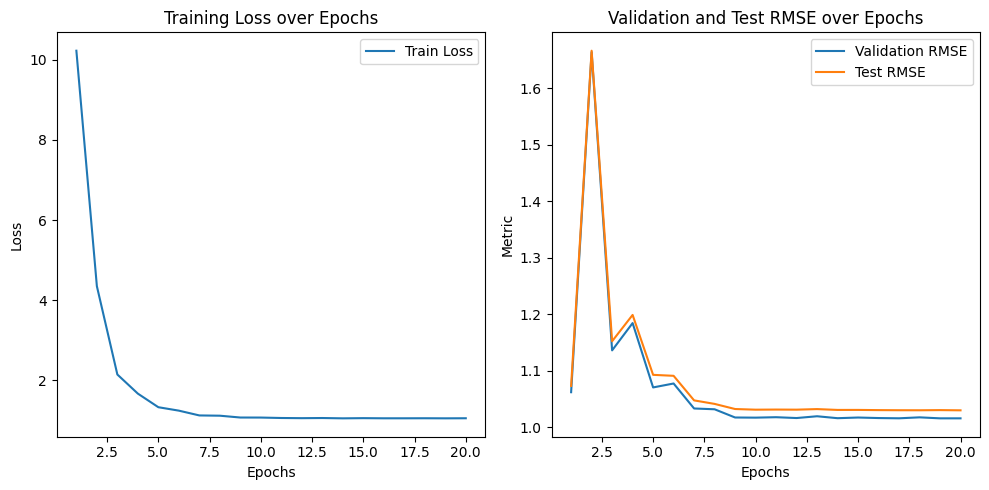

In [ ]:

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(range(1,51))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
# plt.xticks(range(1,51))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.NAdam]  # Add more optimizers as needed
optimizer_names = ['Adam', 'SGD', 'NAdam']  # Match optimizer list
columns = ['Learning Rate', 'Epochs', 'Optimizer', 'Test RMSE']
results_df = pd.DataFrame(columns=columns)

In [ ]:
for lr in learning_rates:
    for opt, opt_name in zip(optimizers, optimizer_names):
        model = Model(hidden_channels=32).to(device)
        optimizer = opt(model.parameters(), lr=lr)
        loss_curve=[]
        Train_curve=[]
        Val_curve=[]
        Test_curve=[]
        for epoch in range(1, 21):
          loss = train(train_loader)
          train_rmse = test(train_loader)
          val_rmse = test(val_loader)
          test_rmse = test(test_loader)
          loss_curve.append(loss)
          Train_curve.append(train_rmse)
          Val_curve.append(val_rmse)
          Test_curve.append(test_rmse)
        # final_test_rmse = np.min(Test_curve)
        # Store the results in the DataFrame
        results_df = results_df.append({'Learning Rate': lr,
                                        'Epochs': 20,
                                        'Optimizer': opt_name,
                                        'Test RMSE': Test_curve},
                                        ignore_index=True)


<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([126, 1])) that is different to the input size (torch.Size([126])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([158, 1])) that is different to the input size (torch.Size([158])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([316, 1])) that is different to the 

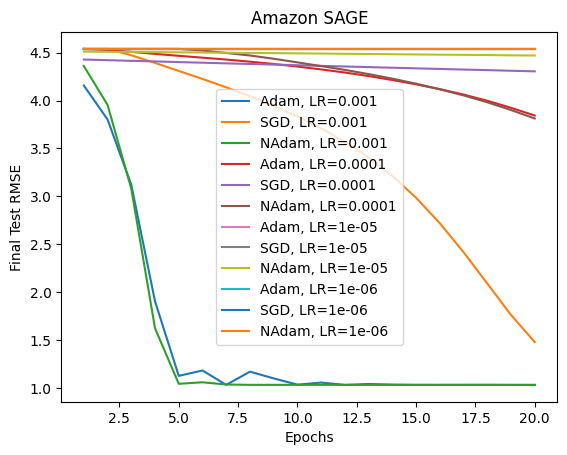

In [ ]:
# Plotting accuracy vs. epochs for each learning rate and optimizer
for lr in learning_rates:
    for opt_name in optimizer_names:
        subset_df = results_df[(results_df['Learning Rate'] == lr) & (results_df['Optimizer'] == opt_name)]
        plt.plot(range(1,21), subset_df['Test RMSE'].tolist()[0], label=f'{opt_name}, LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Final Test RMSE')
plt.title('Amazon SAGE')
plt.legend()
plt.savefig('AMAZON_SAGE.png')
plt.show()

In [ ]:
assert train_data["user", "rates", "item"].edge_label.min() == 1
assert train_data["user", "rates", "item"].edge_label.max() == 5


Baseline GAT

In [29]:
from torch_geometric.nn import GATConv, Linear, to_hetero

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

class GATModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GAT(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)



In [ ]:
model = GATModel(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print('current model = GATModel')

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):#300
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

current model = GATModel
Epoch: 001, Loss: 10.5581, Train: 1.1868, Val: 1.1611, Test: 1.1806


<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([126, 1])) that is different to the input size (torch.Size([126])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([158, 1])) that is different to the input size (torch.Size([158])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([316, 1])) that is different to the 

Epoch: 002, Loss: 2.5753, Train: 1.2027, Val: 1.2017, Test: 1.2082
Epoch: 003, Loss: 1.5868, Train: 1.0291, Val: 1.0180, Test: 1.0327
Epoch: 004, Loss: 1.3928, Train: 1.0308, Val: 1.0203, Test: 1.0343
Epoch: 005, Loss: 1.1981, Train: 1.0338, Val: 1.0259, Test: 1.0384
Epoch: 006, Loss: 1.1312, Train: 1.0349, Val: 1.0203, Test: 1.0360
Epoch: 007, Loss: 1.1023, Train: 1.0398, Val: 1.0355, Test: 1.0442
Epoch: 008, Loss: 1.0728, Train: 1.0411, Val: 1.0247, Test: 1.0401
Epoch: 009, Loss: 1.0793, Train: 1.0324, Val: 1.0269, Test: 1.0367
Epoch: 010, Loss: 1.0575, Train: 1.0283, Val: 1.0165, Test: 1.0308
Epoch: 011, Loss: 1.0607, Train: 1.0260, Val: 1.0163, Test: 1.0302
Epoch: 012, Loss: 1.0566, Train: 1.0259, Val: 1.0172, Test: 1.0304
Epoch: 013, Loss: 1.0549, Train: 1.0269, Val: 1.0157, Test: 1.0301
Epoch: 014, Loss: 1.0583, Train: 1.0257, Val: 1.0159, Test: 1.0300
Epoch: 015, Loss: 1.0555, Train: 1.0259, Val: 1.0167, Test: 1.0304
Epoch: 016, Loss: 1.0547, Train: 1.0271, Val: 1.0157, Test: 1.

In [ ]:
print(data)

HeteroData(
  user={
    x=[262, 404],
    n_id=[262],
  },
  item={
    x=[27, 300],
    n_id=[27],
  },
  (user, rates, item)={
    edge_index=[2, 351],
    edge_label=[126, 1],
    edge_label_index=[2, 126],
    e_id=[351],
    input_id=[126],
  },
  (item, rev_rates, user)={
    edge_index=[2, 1772],
    e_id=[1772],
  }
)


In [ ]:
!pip install captum

In [ ]:

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('Saliency'),
    explanation_type='model', # or phenomenon
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),)

node_index = 10
explanation = explainer(x=train_data.x_dict, edge_index=train_data.edge_index_dict, target=train_data['user', 'item'].edge_label, edge_label_index=train_data['user', 'item'].edge_label_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance_amazon.png'
explanation.visualize_feature_importance(path, top_k=20)
print(f"Feature importance plot has been saved to '{path}'")

# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")


/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:192: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance_amazon.png'


In [ ]:
print(explanation)

HeteroExplanation(
  prediction=[2686],
  target=[2686],
  edge_label_index=[2, 2686],
  user={
    node_mask=[404, 404],
    x=[404, 404],
  },
  item={
    node_mask=[31, 300],
    x=[31, 300],
  },
  (user, rates, item)={
    edge_mask=[2686],
    edge_index=[2, 2686],
  },
  (item, rev_rates, user)={
    edge_mask=[2686],
    edge_index=[2, 2686],
  }
)


In [ ]:
matrix = np.matrix(explanation['user']['node_mask'])
min_vals = matrix.min(axis=0)
max_vals = matrix.max(axis=0)
normalized_matrix = (matrix - min_vals) / (max_vals - min_vals)

In [ ]:
print(normalized_matrix)

[[0.2092926  0.21475944 0.21162648 ... 0.18800893 0.21077138 0.20522775]
 [0.20175946 0.21243966 0.20628007 ... 0.19896315 0.19829217 0.2016962 ]
 [0.3469257  0.35642081 0.35022926 ... 0.33744398 0.34445682 0.34513608]
 ...
 [0.27518573 0.28719422 0.28009796 ... 0.24932984 0.27480653 0.27073628]
 [0.3503999  0.35278636 0.35185373 ... 0.34756094 0.35044163 0.3494095 ]
 [0.35065043 0.36218852 0.35541806 ... 0.3376698  0.34829172 0.34866303]]


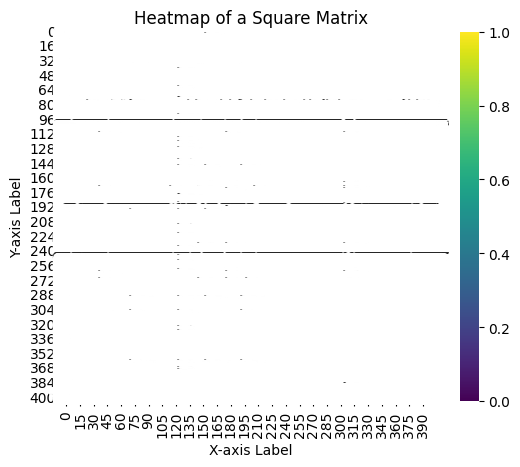

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example square matrix
# Replace this with your actual square matrix data
# matrix = explanation['user']['node_mask']

# Plotting the heatmap
# plt.figure(figsize=(8, 6))  # Adjust the size as needed
sns.heatmap(normalized_matrix, annot=True, cmap='viridis', square=True)

# Adding titles and labels as necessary
plt.title('Heatmap of a Square Matrix')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

plt.show()


In [ ]:
import captum
from torch_geometric.explain import CaptumExplainer
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('Saliency'),
    explanation_type='phenomenon', # or
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),)

node_index = 10
explanation = explainer(x=train_data.x_dict, edge_index=train_data.edge_index_dict, target=train_data['user', 'item'].edge_label, edge_label_index=train_data['user', 'item'].edge_label_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance_amazon_phenomenon.png'
explanation.visualize_feature_importance(path, top_k=20)
print(f"Feature importance plot has been saved to '{path}'")

# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")


/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance_amazon_phenomenon.png'


In [ ]:
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('GAT_amazon_512_3.csv', index=False)

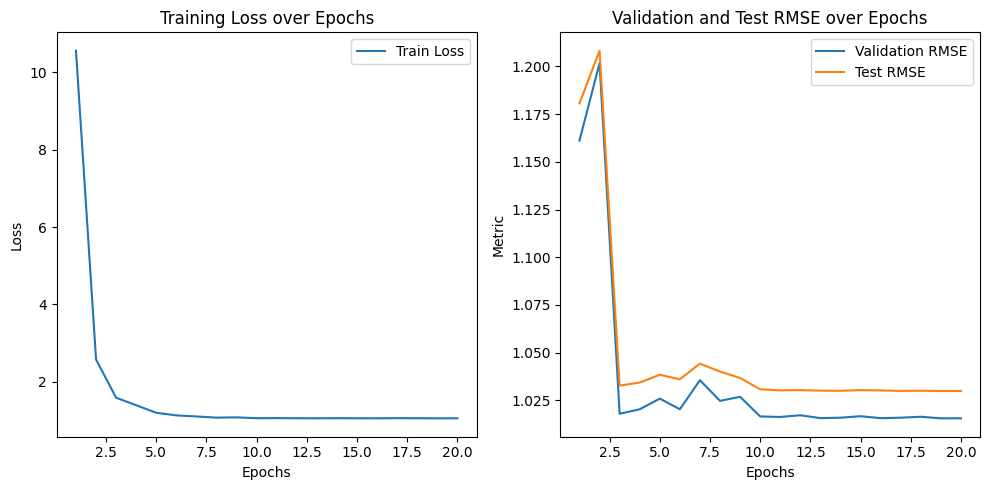

In [ ]:

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(range(1,51))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
# plt.xticks(range(1,51))
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([126, 1])) that is different to the input size (torch.Size([126])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([158, 1])) that is different to the input size (torch.Size([158])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-192-f3c4633bb9e3>:90: UserWarning: Using a target size (torch.Size([316, 1])) that is different to the 

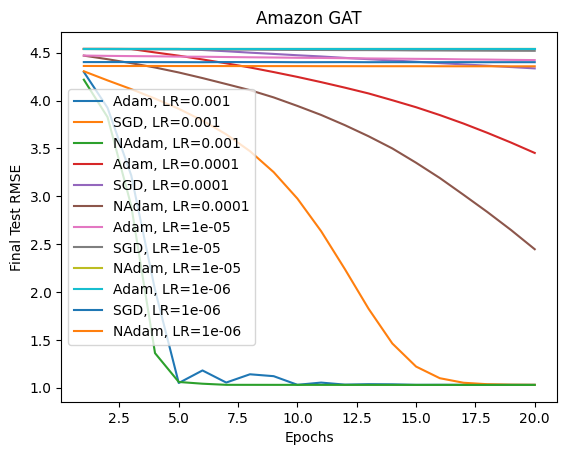

In [ ]:
learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.NAdam]  # Add more optimizers as needed
optimizer_names = ['Adam', 'SGD', 'NAdam']  # Match optimizer list
columns = ['Learning Rate', 'Epochs', 'Optimizer', 'Test RMSE']
results_df = pd.DataFrame(columns=columns)

for lr in learning_rates:
    for opt, opt_name in zip(optimizers, optimizer_names):
        model = GATModel(hidden_channels=32).to(device)
        optimizer = opt(model.parameters(), lr=lr)
        loss_curve=[]
        Train_curve=[]
        Val_curve=[]
        Test_curve=[]
        for epoch in range(1, 21):
          loss = train(train_loader)
          train_rmse = test(train_loader)
          val_rmse = test(val_loader)
          test_rmse = test(test_loader)
          loss_curve.append(loss)
          Train_curve.append(train_rmse)
          Val_curve.append(val_rmse)
          Test_curve.append(test_rmse)
        # final_test_rmse = np.min(Test_curve)
        # Store the results in the DataFrame
        results_df = results_df.append({'Learning Rate': lr,
                                        'Epochs': 20,
                                        'Optimizer': opt_name,
                                        'Test RMSE': Test_curve},
                                        ignore_index=True)
# Plotting accuracy vs. epochs for each learning rate and optimizer
for lr in learning_rates:
    for opt_name in optimizer_names:
        subset_df = results_df[(results_df['Learning Rate'] == lr) & (results_df['Optimizer'] == opt_name)]
        plt.plot(range(1,21), subset_df['Test RMSE'].tolist()[0], label=f'{opt_name}, LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Final Test RMSE')
plt.title('Amazon GAT')
plt.legend()
plt.savefig('AMAZON_GAT.png')
plt.show()

Drugs.com

In [7]:
train_data_drug = pd.read_csv("/content/drive/MyDrive/data/drugscom/drugsComTrain_raw.tsv", delimiter='\t').dropna()
test_data_drug = pd.read_csv("/content/drive/MyDrive/data/drugscom/drugsComTest_raw.tsv", delimiter='\t').dropna()
combined_data = pd.concat([train_data_drug, test_data_drug], ignore_index=True)
combined_data.drop(['Unnamed: 0'], axis=1, inplace=True)
numerical_stats = combined_data.describe()
unique_counts = combined_data[['drugName', 'condition']].nunique()

numerical_stats, unique_counts

(              rating    usefulCount
 count  213869.000000  213869.000000
 mean        6.991149      28.094118
 std         3.275792      36.401377
 min         1.000000       0.000000
 25%         5.000000       6.000000
 50%         8.000000      16.000000
 75%        10.000000      36.000000
 max        10.000000    1291.000000,
 drugName     3667
 condition     916
 dtype: int64)

In [8]:
missing_values = combined_data.isnull().sum()
missing_values

drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [9]:
user_mapping = {index: i for i, index in enumerate(combined_data.condition.unique())}
item_mapping = {index: i for i, index in enumerate(combined_data.drugName.unique())}


In [10]:
keys_with_value = [key for key, value in item_mapping.items() if value == 225]
keys_with_value

['Anastrozole']

In [11]:
keys_with_value = [key for key, value in user_mapping.items() if value == 278]
keys_with_value

['Hyperprolactinemia']

In [12]:
drug_feature={}
for drug, reviews in combined_data.groupby('drugName')['review']:
  item_reviews=[]
  for review in reviews:
    item_reviews.append(text2vector(review))
  reviews_tensor = torch.cat(item_reviews)
  item_mean = torch.mean(reviews_tensor,dim=0)
  drug_feature[drug] = item_mean

In [13]:
condition_feature={}
for condition in combined_data.condition.unique():
  condition_fea = text2vector(condition)
  condition_feature[condition] = condition_fea

In [14]:
data = HeteroData()

In [15]:
item_embeddings=torch.zeros([len(item_mapping),300])
for drug in item_mapping.keys():
  idx=item_mapping[drug]
  item_embeddings[idx]=drug_feature[drug]
data['item'].x = item_embeddings

In [16]:
user_embeddings=torch.zeros([len(user_mapping),300])
for condition in user_mapping.keys():
  idx=user_mapping[condition]
  user_embeddings[idx]=condition_feature[condition]
data['user'].x = user_embeddings

In [17]:
user_item_edge_index = []
for index, row in combined_data.iterrows():
  user_item_edge_index.append([user_mapping[row['condition']],item_mapping[row['drugName']]])
user_item_edge_index = torch.tensor(user_item_edge_index).t()
user_item_edge_index.shape

torch.Size([2, 213869])

In [18]:
user_item_edge_label = []
for index, row in combined_data.iterrows():
  user_item_edge_label.append(row['rating'])
user_item_edge_label = torch.tensor(user_item_edge_label).view(-1,1)
print(user_item_edge_label)
user_item_edge_label.shape

tensor([[9.],
        [8.],
        [5.],
        ...,
        [8.],
        [1.],
        [9.]])


torch.Size([213869, 1])

In [19]:
data['user', 'rates', 'item'].edge_index = user_item_edge_index
data['user', 'rates', 'item'].edge_label = user_item_edge_label
print(data)

HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 213869],
    edge_label=[213869, 1],
  }
)


In [20]:
# 1. Add a reverse ('movie', 'rev_rates', 'user') relation for message passing.
data = ToUndirected()(data)
del data['item', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.
torch.save(data, '/content/drive/MyDrive/data/drugcom.pt')
print(data)
# 2. Perform a link-level split into training, validation, and test edges.
transform = RandomLinkSplit(
    num_val=0.05,   #0.1
    num_test=0.1,   #0.1
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(data)
print(train_data)
print(val_data)
print(test_data)

HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 213869],
    edge_label=[213869, 1],
  },
  (item, rev_rates, user)={ edge_index=[2, 213869] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 181790],
    edge_label=[181790, 1],
    edge_label_index=[2, 181790],
  },
  (item, rev_rates, user)={ edge_index=[2, 181790] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 181790],
    edge_label=[10693, 1],
    edge_label_index=[2, 10693],
  },
  (item, rev_rates, user)={ edge_index=[2, 181790] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 192483],
    edge_label=[21386, 1],
    edge_label_index=[2, 21386],
  },
  (item, rev_rates, user)={ edge_index=[2, 192483] }
)


In [25]:
train_loader = LinkNeighborLoader(
    train_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in train_data.edge_types},
    # Use a batch size of 128 for sampling training edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),train_data['user', 'rates', 'item'].edge_label_index),
    edge_label = train_data['user', 'rates', 'item'].edge_label
)
val_loader = LinkNeighborLoader(
    val_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in val_data.edge_types},
    # Use a batch size of 128 for sampling validation edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),val_data['user', 'rates', 'item'].edge_label_index),
    edge_label = val_data['user', 'rates', 'item'].edge_label
)
test_loader = LinkNeighborLoader(
    test_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in test_data.edge_types},
    # Use a batch size of 128 for sampling testing edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),test_data['user', 'rates', 'item'].edge_label_index),
    edge_label = test_data['user', 'rates', 'item'].edge_label
)

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [35]:

@torch.no_grad()
def test(loader):
    model.eval()
    rmse_list = []
    for data in loader:
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'item'].edge_label_index)
        pred = pred.clamp(min=0, max=10)
        target = data['user', 'item'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        rmse_list.append(rmse)
    return np.mean(rmse_list)



In [36]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):#300
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')


<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([453, 1])) that is different to the input size (torch.Size([453])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([394, 1])) that is different to the input 

Epoch: 001, Loss: 11.2950, Train: 3.4424, Val: 3.4332, Test: 3.4387
Epoch: 002, Loss: 10.8587, Train: 3.4866, Val: 3.4779, Test: 3.4826
Epoch: 003, Loss: 10.8425, Train: 3.4968, Val: 3.4889, Test: 3.4930
Epoch: 004, Loss: 10.8483, Train: 3.4234, Val: 3.4150, Test: 3.4218
Epoch: 005, Loss: 10.8387, Train: 3.3477, Val: 3.3381, Test: 3.3476
Epoch: 006, Loss: 10.8229, Train: 3.3355, Val: 3.3253, Test: 3.3357
Epoch: 007, Loss: 10.8131, Train: 3.3420, Val: 3.3320, Test: 3.3418
Epoch: 008, Loss: 10.8140, Train: 3.3494, Val: 3.3392, Test: 3.3487
Epoch: 009, Loss: 10.8082, Train: 3.3287, Val: 3.3182, Test: 3.3287
Epoch: 010, Loss: 10.7965, Train: 3.3171, Val: 3.3063, Test: 3.3176
Epoch: 011, Loss: 10.7960, Train: 3.3050, Val: 3.2936, Test: 3.3059
Epoch: 012, Loss: 10.7922, Train: 3.3040, Val: 3.2927, Test: 3.3049
Epoch: 013, Loss: 10.7836, Train: 3.3104, Val: 3.2990, Test: 3.3108
Epoch: 014, Loss: 10.7859, Train: 3.3126, Val: 3.3008, Test: 3.3124
Epoch: 015, Loss: 10.7773, Train: 3.3359, Val: 3

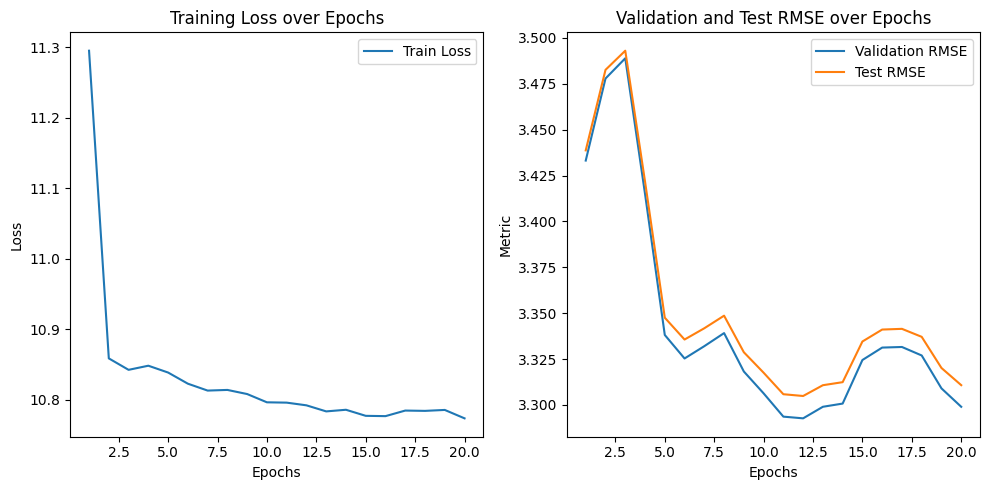

In [37]:

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(range(1,51))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
# plt.xticks(range(1,51))
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
#save loss,train,val,test to pd.csv
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('SAGE_drug_512_2.csv', index=False)

<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([453, 1])) that is different to the input size (torch.Size([453])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  rmse = F.mse_loss(pred, target).sqrt()
<ipython-input-35-18cfbe06ebd5>:10: UserWarning: Using a target size (torch.Size([394, 1])) that is different to the input 

Epoch: 001, Loss: 11.4707, Train: 3.5003, Val: 3.4890, Test: 3.4942
Epoch: 002, Loss: 10.8497, Train: 3.4952, Val: 3.4845, Test: 3.4893
Epoch: 003, Loss: 10.8514, Train: 3.4915, Val: 3.4804, Test: 3.4849
Epoch: 004, Loss: 10.8443, Train: 3.3632, Val: 3.3502, Test: 3.3592
Epoch: 005, Loss: 10.8176, Train: 3.3413, Val: 3.3273, Test: 3.3375
Epoch: 006, Loss: 10.8046, Train: 3.3427, Val: 3.3284, Test: 3.3386
Epoch: 007, Loss: 10.7969, Train: 3.3272, Val: 3.3121, Test: 3.3231
Epoch: 008, Loss: 10.7919, Train: 3.3106, Val: 3.2951, Test: 3.3070
Epoch: 009, Loss: 10.7890, Train: 3.3033, Val: 3.2873, Test: 3.2996
Epoch: 010, Loss: 10.7845, Train: 3.3111, Val: 3.2948, Test: 3.3071
Epoch: 011, Loss: 10.7814, Train: 3.3335, Val: 3.3180, Test: 3.3287
Epoch: 012, Loss: 10.7869, Train: 3.3447, Val: 3.3295, Test: 3.3395
Epoch: 013, Loss: 10.7937, Train: 3.3358, Val: 3.3201, Test: 3.3308
Epoch: 014, Loss: 10.7798, Train: 3.3040, Val: 3.2871, Test: 3.2997
Epoch: 015, Loss: 10.7695, Train: 3.2972, Val: 3

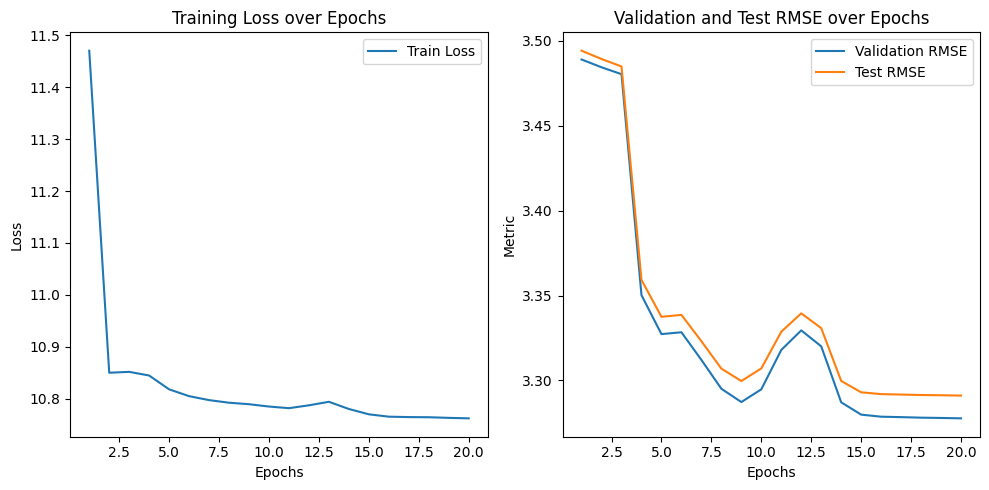

In [39]:
model = GATModel(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):#300
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
#save loss,train,val,test to pd.csv
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('GAT_drug_512_3.csv', index=False)

In [41]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('Saliency'),
    explanation_type='model', # or phenomenon
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),)

node_index = 10
explanation = explainer(x=train_data.x_dict, edge_index=train_data.edge_index_dict, target=train_data['user', 'item'].edge_label, edge_label_index=train_data['user', 'item'].edge_label_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance_drug.png'
explanation.visualize_feature_importance(path, top_k=20)
print(f"Feature importance plot has been saved to '{path}'")

/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:192: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to 'feature_importance_drug.png'


In [42]:
from collections import defaultdict

# Original edges and edge labels
edge_index = data['user', 'rates', 'item'].edge_index
edge_label = data['user', 'rates', 'item'].edge_label

# Dictionary to store aggregated labels
edge_label_dict = defaultdict(list)

# Aggregate labels
for i, (src, dest) in enumerate(edge_index.t()):
    edge_label_dict[(src.item(), dest.item())].append(edge_label[i])

# Calculate mean and create new edge index and edge attributes
new_edge_index = []
new_edge_label = []

for (src, dest), labels in edge_label_dict.items():
    new_edge_index.append([src, dest])
    new_edge_label.append(sum(labels) / len(labels))

new_edge_index = torch.tensor(new_edge_index).t().contiguous()
new_edge_label = torch.tensor(new_edge_label)

mean_data=HeteroData()
# Update the HeteroData object
mean_data['user', 'rates', 'item'].edge_index = new_edge_index
mean_data['user', 'rates', 'item'].edge_label = new_edge_label
mean_data['item'].x = item_embeddings
mean_data['user'].x = user_embeddings
print(mean_data)
mean_data = ToUndirected()(mean_data)
del mean_data['item', 'rev_rates', 'user'].edge_label
torch.save(mean_data, '/content/drive/MyDrive/data/mean_drugcom.pt')
print(mean_data)
transform = RandomLinkSplit(
    num_val=0.05,   #0.1
    num_test=0.1,   #0.1
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'item')],
    rev_edge_types=[('item', 'rev_rates', 'user')],
)
train_data, val_data, test_data = transform(mean_data)
print(train_data)
print(val_data)
print(test_data)
train_loader = LinkNeighborLoader(
    train_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in train_data.edge_types},
    # Use a batch size of 128 for sampling training edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),train_data['user', 'rates', 'item'].edge_label_index),
    edge_label = train_data['user', 'rates', 'item'].edge_label
)
val_loader = LinkNeighborLoader(
    val_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in val_data.edge_types},
    # Use a batch size of 128 for sampling validation edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),val_data['user', 'rates', 'item'].edge_label_index),
    edge_label = val_data['user', 'rates', 'item'].edge_label
)
test_loader = LinkNeighborLoader(
    test_data,
    # Sample 30 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [30] * 2 for key in test_data.edge_types},
    # Use a batch size of 128 for sampling testing edges of type (user rates item)
    batch_size=512,
    edge_label_index=(('user', 'rates', 'item'),test_data['user', 'rates', 'item'].edge_label_index),
    edge_label = test_data['user', 'rates', 'item'].edge_label
)

HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 9446],
    edge_label=[9446],
  }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 9446],
    edge_label=[9446],
  },
  (item, rev_rates, user)={ edge_index=[2, 9446] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 8030],
    edge_label=[8030],
    edge_label_index=[2, 8030],
  },
  (item, rev_rates, user)={ edge_index=[2, 8030] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 8030],
    edge_label=[472],
    edge_label_index=[2, 472],
  },
  (item, rev_rates, user)={ edge_index=[2, 8030] }
)
HeteroData(
  item={ x=[3667, 300] },
  user={ x=[916, 300] },
  (user, rates, item)={
    edge_index=[2, 8502],
    edge_label=[944],
    edge_label_index=[2, 944],
  },
  (item, rev_rates, user)={ edge_index=[2, 

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Epoch: 001, Loss: 20.1174, Train: 2.8624, Val: 2.7918, Test: 2.9929
Epoch: 002, Loss: 6.8471, Train: 2.5340, Val: 2.8673, Test: 2.9582
Epoch: 003, Loss: 5.7282, Train: 2.3515, Val: 2.4907, Test: 2.7092
Epoch: 004, Loss: 5.3724, Train: 2.2966, Val: 2.5531, Test: 2.7217
Epoch: 005, Loss: 5.2743, Train: 2.2752, Val: 2.5295, Test: 2.7103
Epoch: 006, Loss: 5.1786, Train: 2.2558, Val: 2.5038, Test: 2.7000
Epoch: 007, Loss: 5.1341, Train: 2.2406, Val: 2.4746, Test: 2.6927
Epoch: 008, Loss: 5.1206, Train: 2.2268, Val: 2.4349, Test: 2.6804
Epoch: 009, Loss: 5.0953, Train: 2.2369, Val: 2.4091, Test: 2.6762
Epoch: 010, Loss: 5.0503, Train: 2.2493, Val: 2.3758, Test: 2.6848
Epoch: 011, Loss: 4.9671, Train: 2.2454, Val: 2.3625, Test: 2.6853
Epoch: 012, Loss: 4.8757, Train: 2.2228, Val: 2.3600, Test: 2.6864
Epoch: 013, Loss: 4.8021, Train: 2.1949, Val: 2.3617, Test: 2.6881
Epoch: 014, Loss: 4.7460, Train: 2.1798, Val: 2.3635, Test: 2.6894
Epoch: 015, Loss: 4.6912, Train: 2.1632, Val: 2.3671, Test: 2

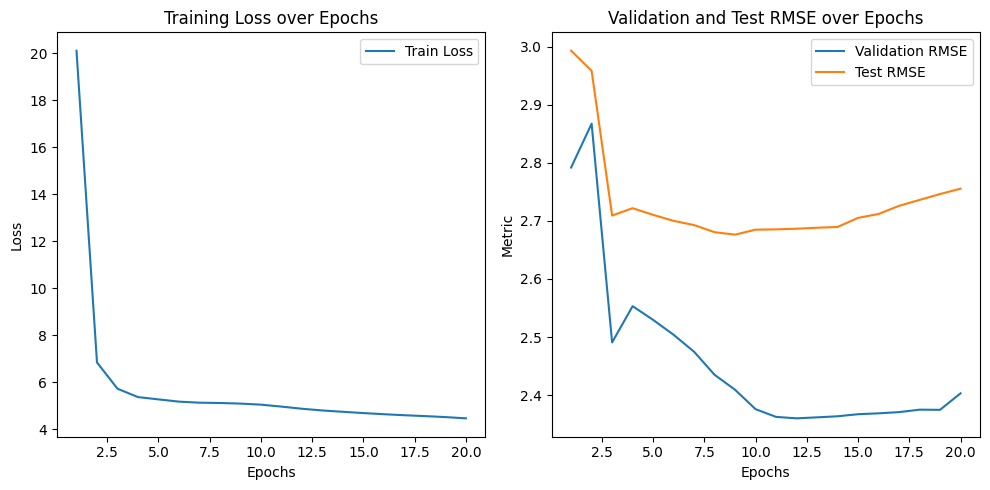

In [43]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):#300
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.xticks(range(1,51))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
# plt.xticks(range(1,51))
plt.legend()

plt.tight_layout()
plt.show()

#save loss,train,val,test to pd.csv
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('SAGE_mean_drug_512_4.csv', index=False)

In [44]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('Saliency'),
    explanation_type='model', # or phenomenon
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),)

node_index = 10
explanation = explainer(x=train_data.x_dict, edge_index=train_data.edge_index_dict, target=train_data['user', 'item'].edge_label, edge_label_index=train_data['user', 'item'].edge_label_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance_mean_drug.png'
explanation.visualize_feature_importance(path, top_k=20)
print(f"Feature importance plot has been saved to '{path}'")

/usr/local/lib/python3.10/dist-packages/torch_geometric/explain/explainer.py:192: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 1 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to 'feature_importance_mean_drug.png'


<ipython-input-45-282aded6b1e9>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-45-282aded6b1e9>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-45-282aded6b1e9>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-45-282aded6b1e9>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-45-282aded6b1e9>:25: FutureWarning: The frame.append method is deprecated and will be rem

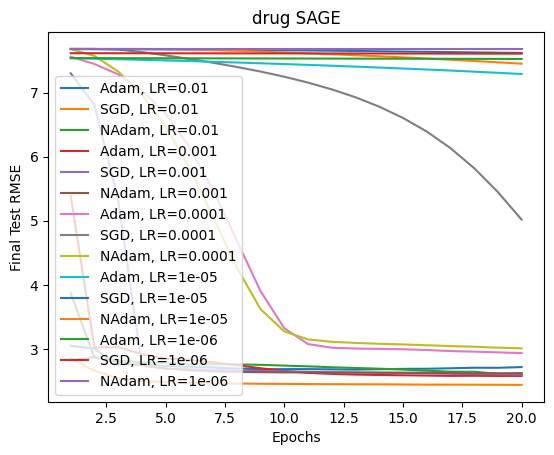

In [45]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.NAdam]  # Add more optimizers as needed
optimizer_names = ['Adam', 'SGD', 'NAdam']  # Match optimizer list
columns = ['Learning Rate', 'Epochs', 'Optimizer', 'Test RMSE']
results_df = pd.DataFrame(columns=columns)
for lr in learning_rates:
    for opt, opt_name in zip(optimizers, optimizer_names):
        model = Model(hidden_channels=32).to(device)
        optimizer = opt(model.parameters(), lr=lr)
        loss_curve=[]
        Train_curve=[]
        Val_curve=[]
        Test_curve=[]
        for epoch in range(1, 21):
          loss = train(train_loader)
          train_rmse = test(train_loader)
          val_rmse = test(val_loader)
          test_rmse = test(test_loader)
          loss_curve.append(loss)
          Train_curve.append(train_rmse)
          Val_curve.append(val_rmse)
          Test_curve.append(test_rmse)
        # final_test_rmse = np.min(Test_curve)
        # Store the results in the DataFrame
        results_df = results_df.append({'Learning Rate': lr,
                                        'Epochs': 20,
                                        'Optimizer': opt_name,
                                        'Test RMSE': Test_curve},
                                        ignore_index=True)
# Plotting accuracy vs. epochs for each learning rate and optimizer
for lr in learning_rates:
    for opt_name in optimizer_names:
        subset_df = results_df[(results_df['Learning Rate'] == lr) & (results_df['Optimizer'] == opt_name)]
        plt.plot(range(1,21), subset_df['Test RMSE'].tolist()[0], label=f'{opt_name}, LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Final Test RMSE')
plt.title('drug SAGE')
plt.legend()
plt.savefig('meandrug_SAGE.png')
plt.show()

Epoch: 001, Loss: 21.1439, Train: 3.1169, Val: 2.9929, Test: 3.2617
Epoch: 002, Loss: 7.3559, Train: 2.4070, Val: 2.8302, Test: 2.9657
Epoch: 003, Loss: 5.5760, Train: 2.2981, Val: 2.6260, Test: 2.8443
Epoch: 004, Loss: 5.2753, Train: 2.2739, Val: 2.6988, Test: 2.8852
Epoch: 005, Loss: 5.1196, Train: 2.2369, Val: 2.6724, Test: 2.8838
Epoch: 006, Loss: 4.9855, Train: 2.2089, Val: 2.6726, Test: 2.8991
Epoch: 007, Loss: 4.9094, Train: 2.1827, Val: 2.6237, Test: 2.8736
Epoch: 008, Loss: 4.8447, Train: 2.1732, Val: 2.5763, Test: 2.8539
Epoch: 009, Loss: 4.7603, Train: 2.1713, Val: 2.5381, Test: 2.8413
Epoch: 010, Loss: 4.6469, Train: 2.1611, Val: 2.5220, Test: 2.8378
Epoch: 011, Loss: 4.5338, Train: 2.1315, Val: 2.5060, Test: 2.8305
Epoch: 012, Loss: 4.4236, Train: 2.0928, Val: 2.4989, Test: 2.8204
Epoch: 013, Loss: 4.3423, Train: 2.0665, Val: 2.4969, Test: 2.8219
Epoch: 014, Loss: 4.2771, Train: 2.0476, Val: 2.4764, Test: 2.8061
Epoch: 015, Loss: 4.2128, Train: 2.0348, Val: 2.4862, Test: 2

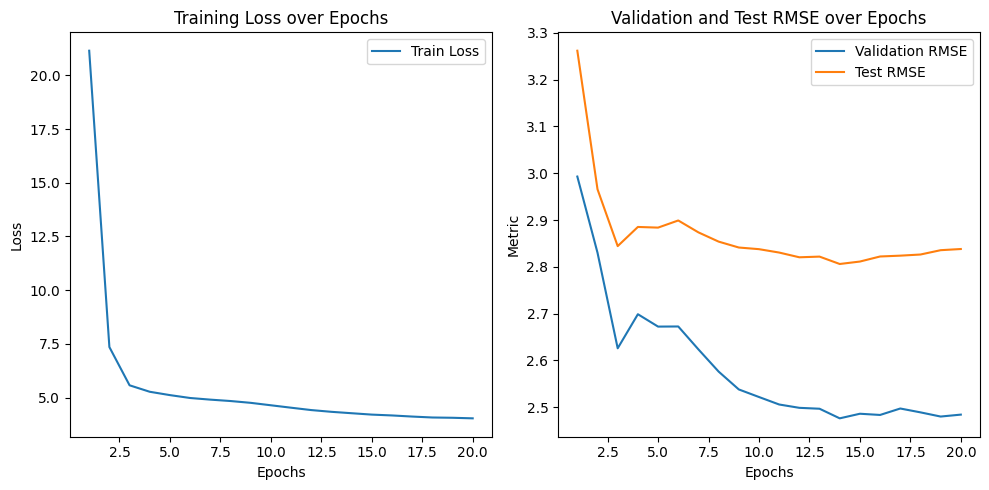

In [51]:
model = GATModel(hidden_channels=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_curve=[]
Train_curve=[]
Val_curve=[]
Test_curve=[]
for epoch in range(1, 21):#300
    loss = train(train_loader)
    train_rmse = test(train_loader)
    val_rmse = test(val_loader)
    test_rmse = test(test_loader)
    loss_curve.append(loss)
    Train_curve.append(train_rmse)
    Val_curve.append(val_rmse)
    Test_curve.append(test_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

# Plotting accuracy vs. epochs for each learning rate and optimizer
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1,21),loss_curve, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1,21),Val_curve, label='Validation RMSE')
plt.plot(range(1,21),Test_curve, label='Test RMSE')
plt.title('Validation and Test RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
#save loss,train,val,test to pd.csv
result_df = pd.DataFrame({'loss':loss_curve,'train':Train_curve,'val':Val_curve,'test':Test_curve})
result_df.to_csv('GAT_mean_drug_512_3.csv', index=False)

<ipython-input-48-e181b08c2fba>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-48-e181b08c2fba>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-48-e181b08c2fba>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-48-e181b08c2fba>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Learning Rate': lr,
<ipython-input-48-e181b08c2fba>:26: FutureWarning: The frame.append method is deprecated and will be rem

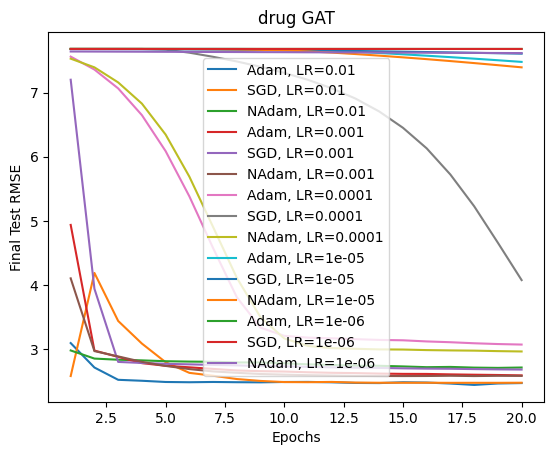

In [48]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
optimizers = [torch.optim.Adam, torch.optim.SGD, torch.optim.NAdam]  # Add more optimizers as needed
optimizer_names = ['Adam', 'SGD', 'NAdam']  # Match optimizer list
columns = ['Learning Rate', 'Epochs', 'Optimizer', 'Test RMSE']
results_df = pd.DataFrame(columns=columns)

for lr in learning_rates:
    for opt, opt_name in zip(optimizers, optimizer_names):
        model = GATModel(hidden_channels=32).to(device)
        optimizer = opt(model.parameters(), lr=lr)
        loss_curve=[]
        Train_curve=[]
        Val_curve=[]
        Test_curve=[]
        for epoch in range(1, 21):
          loss = train(train_loader)
          train_rmse = test(train_loader)
          val_rmse = test(val_loader)
          test_rmse = test(test_loader)
          loss_curve.append(loss)
          Train_curve.append(train_rmse)
          Val_curve.append(val_rmse)
          Test_curve.append(test_rmse)
        # final_test_rmse = np.min(Test_curve)
        # Store the results in the DataFrame
        results_df = results_df.append({'Learning Rate': lr,
                                        'Epochs': 20,
                                        'Optimizer': opt_name,
                                        'Test RMSE': Test_curve},
                                        ignore_index=True)
# Plotting accuracy vs. epochs for each learning rate and optimizer
for lr in learning_rates:
    for opt_name in optimizer_names:
        subset_df = results_df[(results_df['Learning Rate'] == lr) & (results_df['Optimizer'] == opt_name)]
        plt.plot(range(1,21), subset_df['Test RMSE'].tolist()[0], label=f'{opt_name}, LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Final Test RMSE')
plt.title('drug GAT')
plt.legend()
plt.savefig('meandrug_GAT.png')
plt.show()